In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv


In [2]:
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import string
import tensorflow_text as tf_text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
# define the seed value and set the numpy and tensorflow random value to be fixed
seed_value=43
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
sample_df=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

In [6]:
# sample submission.csv ,we need to generate the same
sample_df.head()

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


In [7]:
# load the dataset
df1=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')

In [8]:
# example text of given dataset
df1.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [9]:
#shape of the dataset
df1.shape

(1378, 4)

In [10]:
# value counts of label
df1['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

**This dataset id more imbalanced we need some balance dataset otherwise it will not give satisfactory result
**

In [11]:
df2=pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv')
df3=pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv')
df4=pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv')
df5=pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')

In [12]:
# concatenate the all training dataset
df_final=pd.concat([df2,df3,df4,df5],axis=0)

In [13]:
# rename the label as generated
df_final=df_final.rename(columns={'label':'generated'})

In [14]:
# now concat the first dataframe 'df1'
df_final=pd.concat([df_final,df1],axis=0)

In [15]:
df_final.head()

,text,generated,source,fold,essay_id,prompt,id,prompt_id
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2.0,NaN,NaN,NaN,NaN
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4.0,NaN,NaN,NaN,NaN
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0.0,NaN,NaN,NaN,NaN
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0.0,NaN,NaN,NaN,NaN
4,My argument for the development of the driverl...,0,persuade_corpus,3.0,NaN,NaN,NaN,NaN


In [16]:
# shape of final dataset
df_final.shape

(160834, 8)

In [17]:
# check whether dataset is imbalance or not
df_final['generated'].value_counts()

generated
0    116747
1     44087
Name: count, dtype: int64

In [18]:
df_final.columns

Index(['text', 'generated', 'source', 'fold', 'essay_id', 'prompt', 'id',
       'prompt_id'],
      dtype='object')

In [19]:
# remove the reduntant columns
df_final=df_final.drop(['source','fold','essay_id','prompt_id'],axis=1)

In [20]:
# we miss to remove the one reduntant columns
df_final=df_final.drop(['prompt'],axis=1)

In [21]:
# final dataset 
df_final.head()

,text,generated,id
0,There are alot reasons to keep our the despise...,0,NaN
1,Driving smart cars that drive by themself has ...,0,NaN
2,"Dear Principal,\n\nI believe that students at ...",0,NaN
3,"Dear Principal,\n\nCommunity service should no...",0,NaN
4,My argument for the development of the driverl...,0,NaN


In [22]:
df_final=df_final.drop(['id'],axis=1)

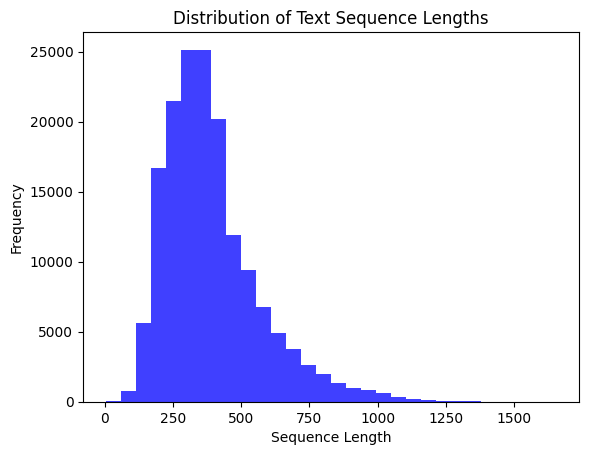

In [23]:
import matplotlib.pyplot as plt
sequence_lengths = df_final['text'].apply(lambda x: len(x.split()))

plt.hist(sequence_lengths, bins=30, alpha=0.75, color='blue')
plt.title('Distribution of Text Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [24]:
# split the dataset into train and test sets
train_df,test_df=train_test_split(df_final,test_size=0.35,random_state=333)

In [25]:
# define batch size and convert the raw dataset into trainable dataset
batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['generated'].values)
).batch(batch_size)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['generated'].values)
).batch(batch_size)

In [26]:
# perform the data pre-processing steps like normalization and vectorization.
max_features = 75000
embedding_dim = 64
sequence_length = 512*2

with tf.device('/GPU:0'):
    def tf_lower_and_split_punct(text):
        text = tf_text.normalize_utf8(text, 'NFKD')
        text = tf.strings.lower(text)
        text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
        text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
        text = tf.strings.strip(text)
        text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
        return text
    
    # Text vectorization layer
    vectorize_layer = tf.keras.layers.TextVectorization(
       standardize=tf_lower_and_split_punct,
       max_tokens=max_features,
       ngrams = (3,5),
       output_mode="int",
       output_sequence_length=sequence_length,
       pad_to_max_tokens=True
    )
    
    text_ds = raw_train_ds.map(lambda x, y: x)
    vectorize_layer.adapt(text_ds)
    
    def vectorize_text(text, label):
        text = tf.expand_dims(text, -1)
        return vectorize_layer(text), label
    
    train_ds = raw_train_ds.map(vectorize_text)
    test_ds = raw_test_ds.map(vectorize_text)


In [27]:
from tensorflow.keras.layers import TextVectorization,Embedding,Bidirectional,Conv1D,LSTM,GlobalMaxPooling1D,Dense,Dropout
from tensorflow.keras import Model,Input

In [28]:
# difine the transformer model 
class Transformer(tf.keras.layers.Layer):
    def __init__(self,embed_dim,num_heads,ff_dim,rate=0.01):
        super(Transformer,self).__init__()
        self.attn=tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
        self.ffn=tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim,activation='relu'),tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-4)
        self.layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-4)
        self.dropout1=Dropout(rate)
        self.dropout2=Dropout(rate)
        
    
    def call(self,inputs, training):
        attn_out=self.attn(inputs,inputs)
        attn_out=self.dropout1(attn_out,training=training)
        out1=self.layernorm1(inputs + attn_out)
        ffn_out=self.ffn(out1)
        ffn_out=self.dropout2(ffn_out,training=training)
        return self.layernorm2(out1+ffn_out)
    

In [29]:
inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
transformer = Transformer(embedding_dim, 2, 32)
x = transformer(x)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

In [30]:
with tf.device('/GPU:0'):
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
    epochs = 2
    model.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/2
3267/3267 [==============================] - 717s 216ms/step - loss: 0.0488 - binary_accuracy: 0.9813 - val_loss: 0.0093 - val_binary_accuracy: 0.9983
Epoch 2/2
3267/3267 [==============================] - 400s 122ms/step - loss: 0.0081 - binary_accuracy: 0.9984 - val_loss: 0.0128 - val_binary_accuracy: 0.9978


In [31]:
test=pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

In [32]:
test_text = test['text'].values
vectorized_test_text = vectorize_layer(test_text)
predictions = model.predict(vectorized_test_text)
test['generated'] = predictions
print(test[['text', 'generated']])

1/1 [==============================] - 1s 924ms/step
           text  generated
0  Aaa bbb ccc.   0.866899
1  Bbb ccc ddd.   0.866899
2  CCC ddd eee.   0.866899


In [33]:
test.head()

,id,prompt_id,text,generated
0,0000aaaa,2,Aaa bbb ccc.,0.866899
1,1111bbbb,3,Bbb ccc ddd.,0.866899
2,2222cccc,4,CCC ddd eee.,0.866899


In [34]:
test=test.drop(['text','prompt_id'],axis=1)

In [35]:
test[['id', 'generated']].set_index('id').to_csv("submission.csv")

In [36]:
test.head()

,id,generated
0,0000aaaa,0.866899
1,1111bbbb,0.866899
2,2222cccc,0.866899
